# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 10.5KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

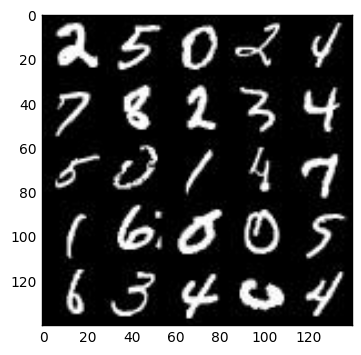

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

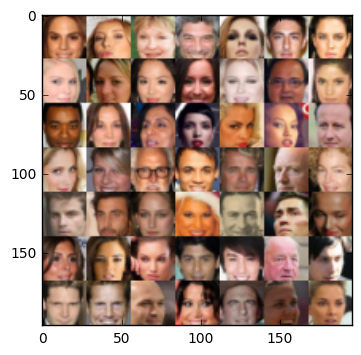

In [13]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/kapy/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [58]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [57]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14*14*128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [66]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [184]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print(input_real)
    d_loss, g_loss = model_loss(input_real, input_z, z_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #print(batch_images)
                step += 1
                #x = batch_images[0]
                #print(batch_images.shape)
                #print(x.shape)
                #x = x.reshape((batch_size, 784))
                #x = x*2 - 1
                #y = batch_images[1]
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_z.shape)

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                # Get images, reshape and rescale to pass to D
                #batch_images = batch[0].reshape((batch_size, 784))
                #batch_images = batch_images*2 - 1
            
                # Sample random noise for G
                #batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
                # Run optimizers
                #_ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if step % 100 == 0:
                    show_generator_output(sess, 10, input_z, z_dim, data_image_mode)
                    
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
            
                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

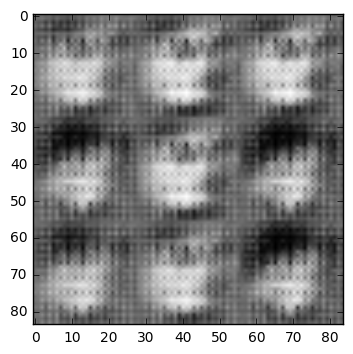

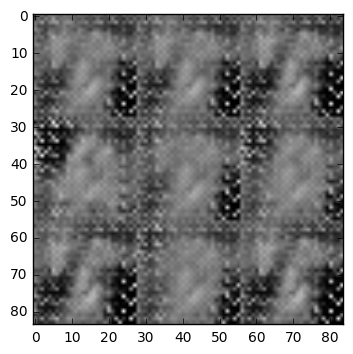

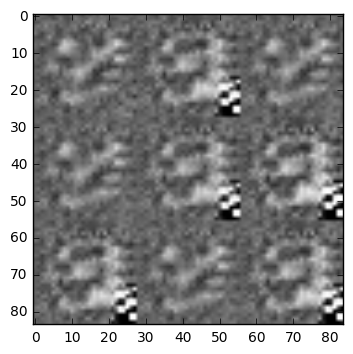

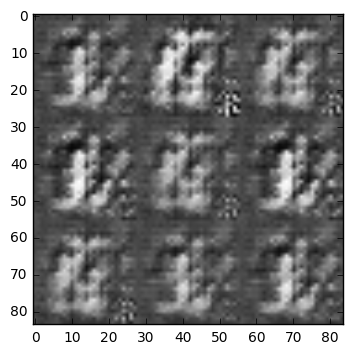

Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 1.2485


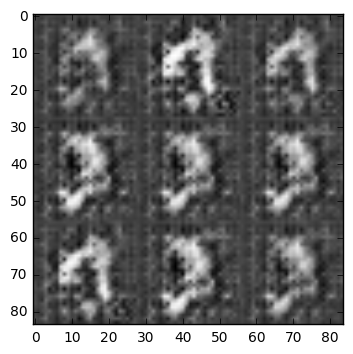

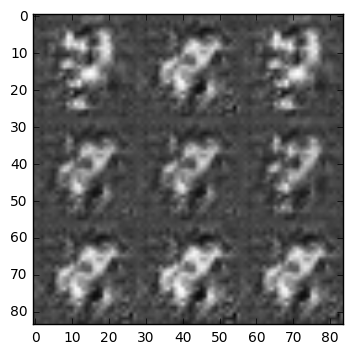

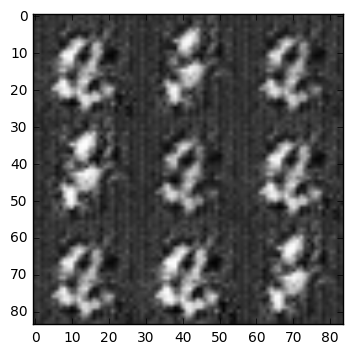

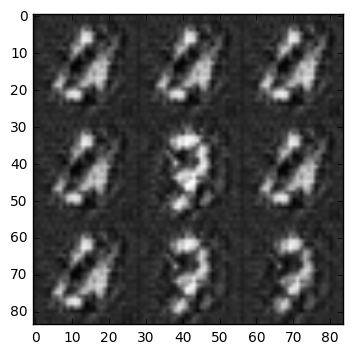

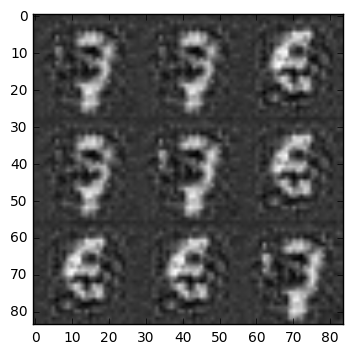

Epoch 2/2... Discriminator Loss: 0.3229... Generator Loss: 2.3617


In [180]:
batch_size = 128
z_dim = 1
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2052... Generator Loss: 0.1426
Epoch 1/1... Discriminator Loss: 3.0210... Generator Loss: 0.0679
Epoch 1/1... Discriminator Loss: 3.0771... Generator Loss: 0.0685
Epoch 1/1... Discriminator Loss: 2.6571... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 2.3530... Generator Loss: 0.1666
Epoch 1/1... Discriminator Loss: 2.0335... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 1.9136... Generator Loss: 0.3542
Epoch 1/1... Discriminator Loss: 1.8118... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.8647... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7592
Epoch 1/1.

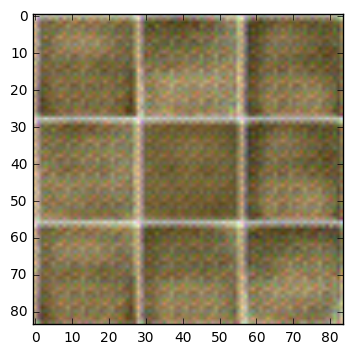

Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 3.0522
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 2.7604
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.9780
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 2.5508
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 1.9578
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 0.9201
Epoch 1/1.

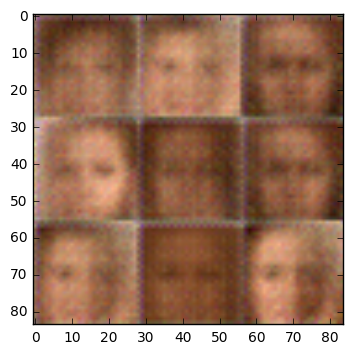

Epoch 1/1... Discriminator Loss: 1.9216... Generator Loss: 0.2022
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 4.4898
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 4.6715
Epoch 1/1... Discriminator Loss: 1.9768... Generator Loss: 0.1883
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 2.7246
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 4.2023
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.2561
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 3.3876
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 3.4393
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.0135
Epoch 1/1.

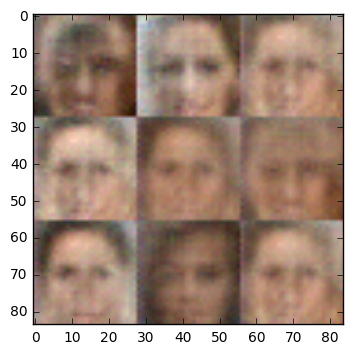

Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 1.9908
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 2.5399
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 3.9064
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 3.2273
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 4.0393
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 4.9085
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 4.1726
Epoch 1/1.

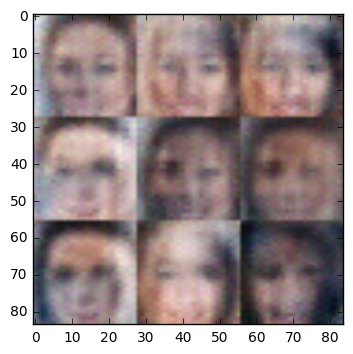

Epoch 1/1... Discriminator Loss: 0.2688... Generator Loss: 3.6768
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 0.2480... Generator Loss: 2.6166
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 2.0024
Epoch 1/1... Discriminator Loss: 0.1769... Generator Loss: 4.1233
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 3.0519
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.6122
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 5.0512
Epoch 1/1... Discriminator Loss: 2.7386... Generator Loss: 0.0767
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 4.6932
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 8.5309
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 6.9815
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.4480
Epoch 1/1.

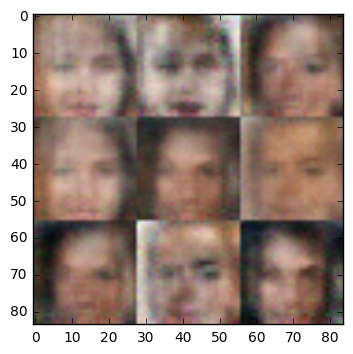

Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 4.5982
Epoch 1/1... Discriminator Loss: 0.3223... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 1.9928
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 3.2085
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 2.4757
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 2.9190
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 3.5539
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 3.8118
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 2.3866
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 5.1364
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 0.8813
Epoch 1/1.

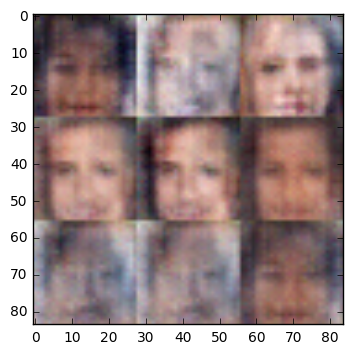

Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.3683
Epoch 1/1... Discriminator Loss: 0.1751... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 0.2219... Generator Loss: 3.6062
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 2.1092
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 3.9086
Epoch 1/1... Discriminator Loss: 0.1647... Generator Loss: 3.5120
Epoch 1/1... Discriminator Loss: 1.8729... Generator Loss: 0.1926
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 4.4819
Epoch 1/1... Discriminator Loss: 0.3065... Generator Loss: 2.9408
Epoch 1/1... Discriminator Loss: 0.2296... Generator Loss: 2.2766
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 4.2578
Epoch 1/1.

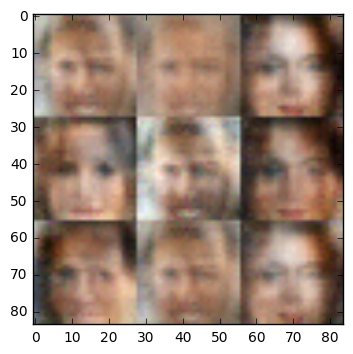

Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 3.3794
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 3.0131
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 2.4406
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 4.8018
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 2.5321
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.3119... Generator Loss: 1.8189
Epoch 1/1... Discriminator Loss: 0.1646... Generator Loss: 3.6871
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 4.7328
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 3.0968
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 2.5119
Epoch 1/1.

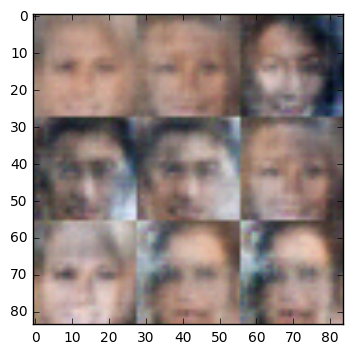

Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 3.9780
Epoch 1/1... Discriminator Loss: 0.1362... Generator Loss: 4.8366
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 3.3241
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 9.4170
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 0.0998... Generator Loss: 8.7189
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 0.1951... Generator Loss: 6.0669
Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 2.5107
Epoch 1/1... Discriminator Loss: 0.2129... Generator Loss: 3.2886
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 2.9460
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 2.7471
Epoch 1/1... Discriminator Loss: 0.2809... Generator Loss: 1.9524
Epoch 1/1.

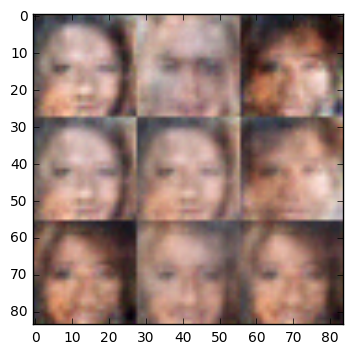

Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 1.5019
Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 4.9175
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 1.2791
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 0.3156... Generator Loss: 2.5134
Epoch 1/1... Discriminator Loss: 0.3218... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.6935
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 5.4523
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 6.5737
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 5.3308
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 2.0404
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 4.7709
Epoch 1/1.

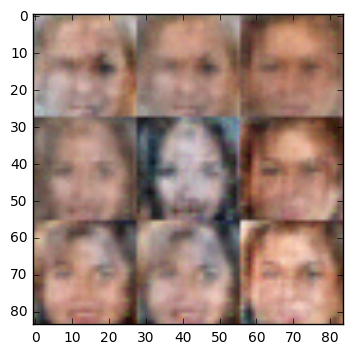

Epoch 1/1... Discriminator Loss: 0.0966... Generator Loss: 4.1650
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 3.8917
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 3.7700
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 1.8815
Epoch 1/1... Discriminator Loss: 0.1707... Generator Loss: 3.5418
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 2.7597
Epoch 1/1... Discriminator Loss: 0.0855... Generator Loss: 5.5850
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 10.6934
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 2.1702
Epoch 1/1... Discriminator Loss: 0.1532... Generator Loss: 4.8826
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 6.0500
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.2096
Epoch 1/1

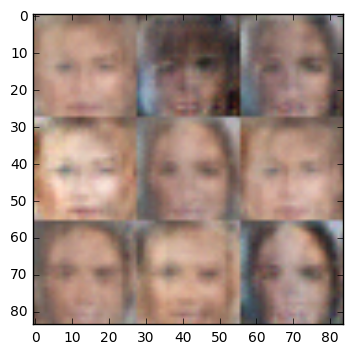

Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 4.1818
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 4.3630
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 5.3089
Epoch 1/1... Discriminator Loss: 0.3189... Generator Loss: 5.5479
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 5.1029
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 3.5652
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 6.6551
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 4.4869
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 3.8094
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 3.3470
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 6.2342
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.6375
Epoch 1/1.

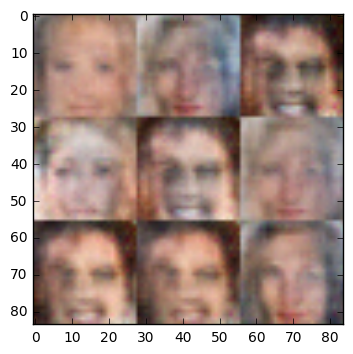

Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 5.7757
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 5.4305
Epoch 1/1... Discriminator Loss: 0.2032... Generator Loss: 3.2903
Epoch 1/1... Discriminator Loss: 0.1245... Generator Loss: 6.3559
Epoch 1/1... Discriminator Loss: 0.2262... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 4.9870
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 4.2687
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 5.2367
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 4.6270
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 9.6411
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 2.9725
Epoch 1/1... Discriminator Loss: 0.0989... Generator Loss: 5.3459
Epoch 1/1.

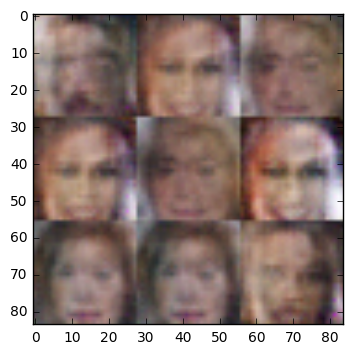

Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 3.1721
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 4.9462
Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 3.2610
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 1.4693
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 6.6698
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 0.2778... Generator Loss: 6.0040
Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 5.6586
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 5.4533
Epoch 1/1... Discriminator Loss: 0.1642... Generator Loss: 3.4349
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 9.4311
Epoch 1/1... Discriminator Loss: 0.2638... Generator Loss: 2.9784
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 11.7443
Epoch 1/1

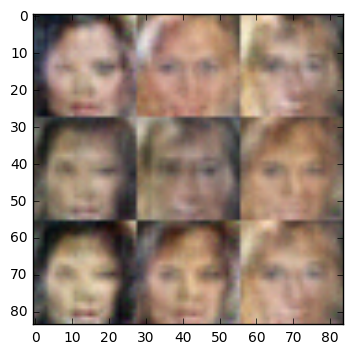

Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 4.4277
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 0.3089... Generator Loss: 11.1789
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 6.0192
Epoch 1/1... Discriminator Loss: 0.0683... Generator Loss: 5.8583
Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 5.0200
Epoch 1/1... Discriminator Loss: 2.3020... Generator Loss: 0.1277
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 9.1509
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 10.9921
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 4.7959
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 9.4791
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 2.5883
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 10.1881
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 6.4215
Epoch 1/1... Discriminator Loss: 0.1025... Generator Loss: 4.4556
Epoch 1

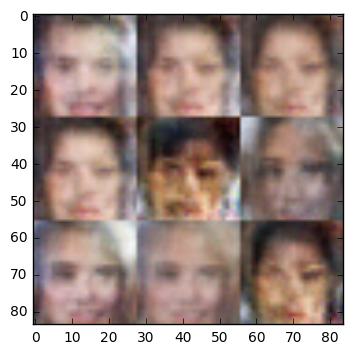

Epoch 1/1... Discriminator Loss: 0.2085... Generator Loss: 3.1731
Epoch 1/1... Discriminator Loss: 0.1027... Generator Loss: 6.2547
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 3.3776
Epoch 1/1... Discriminator Loss: 0.0901... Generator Loss: 4.1162
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 5.6968
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 11.8545
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 5.2355
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 6.9595
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 7.5415
Epoch 1/1... Discriminator Loss: 0.1602... Generator Loss: 3.2900
Epoch 1/1... Discriminator Loss: 0.3073... Generator Loss: 2.4220
Epoch 1/1... Discriminator Loss: 0.2731... Generator Loss: 2.4047
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 5.6254
Epoch 1/1

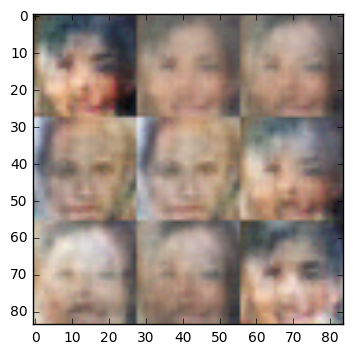

Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 5.7468
Epoch 1/1... Discriminator Loss: 0.2678... Generator Loss: 5.1609
Epoch 1/1... Discriminator Loss: 0.1438... Generator Loss: 5.7255
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.1818... Generator Loss: 9.2194
Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 5.4314
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 6.5830
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.8657
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 1.9834


In [ ]:
batch_size = 100
z_dim = 3
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.